In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler#, #OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier  # MetaEstimador...

from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

from sklearn import set_config
set_config(display='diagram')

import pickle

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('ames_housing.csv').drop(columns='Unnamed: 0')
df

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,Good_Privacy,None,0,3,2006,WD,Normal,142500,-93.604776,41.988964
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,Minimum_Privacy,None,0,6,2006,WD,Normal,131000,-93.602680,41.988314
2927,Split_Foyer,Residential_Low_Density,62,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,Shed,700,7,2006,WD,Normal,132000,-93.606847,41.986510
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Fence,None,0,4,2006,WD,Normal,170000,-93.600190,41.990921


In [3]:
Xi = df.drop(columns = 'Sale_Price')
y = df.Sale_Price

(df.dtypes).unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [4]:
def train_evaluate_model(pipe, X_train, X_test, y_train, y_test):
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred = pipe.predict(X_test)
    print('Train prediction results')
    print(classification_report(y_train, y_pred_train, digits=4))
    print('Test prediction results')
    print(classification_report(y_test, y_pred, digits=4))
    return pipe


cat_variables = Xi.select_dtypes(include=[object]).columns.to_list()
num_variables = Xi.select_dtypes(include=[float, int]).columns.to_list()
# print(num_variables)

prep = Pipeline(steps = [
    ('ord_enc', OneHotEncoder(drop_last=True, variables = cat_variables)),
    # ('sc', SklearnTransformerWrapper(StandardScaler(), variables=num_variables))
])

prep.fit(Xi)
X = prep.transform(Xi)

In [5]:
# utils propios
import helpers as hp

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=11238)

pipe_dt = Pipeline(steps=[
    # ('prep', prep),
    ('model', DecisionTreeRegressor(random_state=11238))
])

pipe_dt.fit(X_train,y_train)


metrics = {
        'r2_score': r2_score,
        'rmse_val': lambda x,y: np.sqrt(mean_squared_error(x,y)),
        'mae_val': median_absolute_error
    }

dt_scores = hp.report_regression_metrics(pipe_dt, X_test, y_test, metrics)
dt_scores

# models = {'gam':gam_scores,'gam_sin_reg':gam_sin_reg_scores}

# Tabla de reporte de performance
# hp.reporte_modelos(models)


{'r2_score': 0.779, 'rmse_val': 35407.317, 'mae_val': 16500.0}

In [6]:
X.shape

(2930, 306)

<AxesSubplot:>

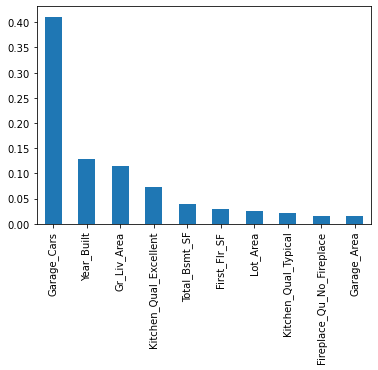

In [7]:
# Importancia de Variables ... que me permiten indicar el protagonismo de la variable al momento de entrenar...
fi = pipe_dt.named_steps.model.feature_importances_
feature_names = prep.named_steps.ord_enc.get_feature_names_out()
pd.Series(fi, index=feature_names).sort_values(ascending=False).iloc[0:10].plot(kind='bar')

In [13]:
params = {
    # hp poderoso, tiempo de entrenamiento...
    'model__max_depth': list(range(1,33))
}

search = GridSearchCV(pipe_dt, params, cv=5, scoring='r2', n_jobs=-1)
search.fit(X_train,y_train)
search_scores = hp.report_regression_metrics(search.best_estimator_, X_test, y_test, metrics)
search_scores

In [9]:
search.best_params_

{'model__max_depth': 7}

In [12]:
save_dict = {}
save_dict['model'] = search.best_estimator_
save_dict['X_train'] = X_train
save_dict['y_train'] = y_train
save_dict['X_test'] = X_test
save_dict['y_test'] = y_test
hp.save_bytes_variable(save_dict,'thomas-peet-actividad07.sav')